In [2]:
import sys, os
sys.path.append(os.pardir)

In [1]:
from pathlib import Path
import numpy as np
import polars as pl
import os
from hydra import initialize, compose
import plotly.express as px

with initialize(config_path="../run/conf", version_base=None):
    cfg = compose("cv_train")

In [3]:
from src.utils.metrics import event_detection_ap
from src.utils.periodicity import get_periodicity_dict
from src.utils.post_process import make_submission
from src.utils.common import trace

periodicity_dict = get_periodicity_dict(cfg)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
event_df = pl.read_csv(Path(cfg.dir.data_dir) / "train_events.csv").drop_nulls()
event_df = event_df.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
)

In [5]:
pred_df = (
    pl.read_parquet("./pred_onset.parquet")
    .rename({"label_pred": "stacking_prediction_onset"})
    .drop("label")
    .join(
        pl.read_parquet("./pred_wakeup.parquet")
        .rename({"label_pred": "stacking_prediction_wakeup"})
        .drop("label"),
        on=["series_id", "step"],
        how="left",
    )
)
pred_df = pred_df.with_columns(
    ((pl.col("step") - pl.col("step").shift(1)) != 12)
    .cast(int)
    .cumsum()
    .over("series_id")
    .fill_null(0)
    .alias("chunk_id")
).with_columns(pl.col('step').cast(pl.UInt32))

In [6]:
pred_df.head()

shape: (5, 5)
┌──────────────┬──────┬───────────────────────────┬────────────────────────────┬──────────┐
│ series_id    ┆ step ┆ stacking_prediction_onset ┆ stacking_prediction_wakeup ┆ chunk_id │
│ ---          ┆ ---  ┆ ---                       ┆ ---                        ┆ ---      │
│ str          ┆ u32  ┆ f64                       ┆ f64                        ┆ i64      │
╞══════════════╪══════╪═══════════════════════════╪════════════════════════════╪══════════╡
│ 038441c925bb ┆ 0    ┆ 0.000008                  ┆ 0.00001                    ┆ 0        │
│ 038441c925bb ┆ 12   ┆ 0.000008                  ┆ 0.000008                   ┆ 0        │
│ 038441c925bb ┆ 24   ┆ 0.000007                  ┆ 0.000031                   ┆ 0        │
│ 038441c925bb ┆ 36   ┆ 0.000009                  ┆ 0.000019                   ┆ 0        │
│ 038441c925bb ┆ 48   ┆ 0.000006                  ┆ 0.000007                   ┆ 0        │
└──────────────┴──────┴───────────────────────────┴────────────────────────────┴──────────┘

In [7]:
train_df = pl.read_parquet(Path(cfg.dir.data_dir) / "train_series.parquet")
train_df = train_df.with_columns(
            pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
        ).filter(pl.col('step')%12==0)
pred_df = pred_df.join(train_df, on=['series_id', 'step'], how='left')


In [8]:
# labelを結合
pred_label_df = pred_df.with_columns(pl.col('step').cast(int)).join(event_df, on=['series_id', 'step'], how='left')
pred_label_df = pred_label_df.with_columns(
    (pl.col('event')=='onset').cast(pl.UInt64).alias('onset_label'),
    (pl.col('event')=='wakeup').cast(pl.UInt64).alias('wakeup_label')
)
pred_label_df.head()

shape: (5, 13)
┌─────────────┬──────┬─────────────┬────────────┬───┬───────┬────────────┬────────────┬────────────┐
│ series_id   ┆ step ┆ stacking_pr ┆ stacking_p ┆ … ┆ event ┆ timestamp_ ┆ onset_labe ┆ wakeup_lab │
│ ---         ┆ ---  ┆ ediction_on ┆ rediction_ ┆   ┆ ---   ┆ right      ┆ l          ┆ el         │
│ str         ┆ i64  ┆ set         ┆ wakeup     ┆   ┆ str   ┆ ---        ┆ ---        ┆ ---        │
│             ┆      ┆ ---         ┆ ---        ┆   ┆       ┆ datetime[μ ┆ u64        ┆ u64        │
│             ┆      ┆ f64         ┆ f64        ┆   ┆       ┆ s, UTC]    ┆            ┆            │
╞═════════════╪══════╪═════════════╪════════════╪═══╪═══════╪════════════╪════════════╪════════════╡
│ 038441c925b ┆ 0    ┆ 0.000008    ┆ 0.00001    ┆ … ┆ null  ┆ null       ┆ null       ┆ null       │
│ b           ┆      ┆             ┆            ┆   ┆       ┆            ┆            ┆            │
│ 038441c925b ┆ 12   ┆ 0.000008    ┆ 0.000008   ┆ … ┆ null  ┆ null       ┆ null       ┆ null       │
│ b           ┆      ┆             ┆            ┆   ┆       ┆            ┆            ┆            │
│ 038441c925b ┆ 24   ┆ 0.000007    ┆ 0.000031   ┆ … ┆ null  ┆ null       ┆ null       ┆ null       │
│ b           ┆      ┆             ┆            ┆   ┆       ┆            ┆            ┆            │
│ 038441c925b ┆ 36   ┆ 0.000009    ┆ 0.000019   ┆ … ┆ null  ┆ null       ┆ null       ┆ null       │
│ b           ┆      ┆             ┆            ┆   ┆       ┆            ┆            ┆            │
│ 038441c925b ┆ 48   ┆ 0.000006    ┆ 0.000007   ┆ … ┆ null  ┆ null       ┆ null       ┆ null       │
│ b           ┆      ┆             ┆            ┆   ┆       ┆            ┆            ┆            │
└─────────────┴──────┴─────────────┴────────────┴───┴───────┴────────────┴────────────┴────────────┘

In [112]:
print(len(pred_label_df))
print(len(pred_label_df.filter(pl.col('timestamp').is_not_null())))

2185759
2184376


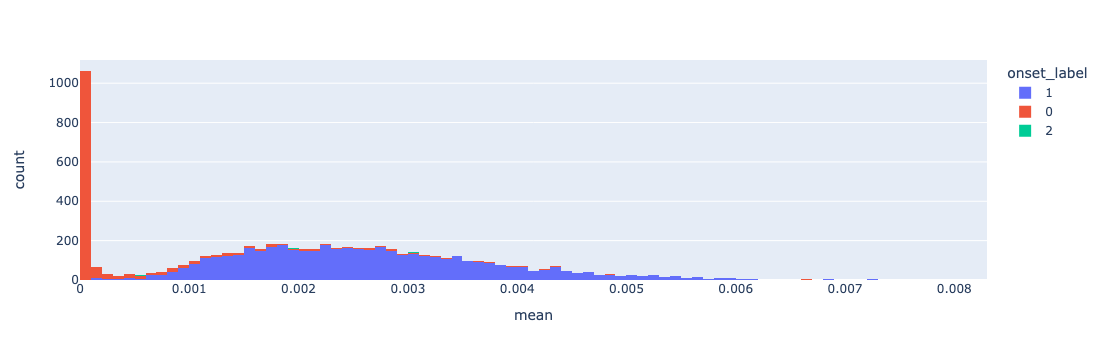

In [29]:
event = 'onset'
event_pred_col = f"stacking_prediction_{event}"

pred_label_df = pred_label_df.with_columns(
    pl.col("timestamp").dt.offset_by("2h").dt.date().alias("date")
)


result_df = pred_label_df.group_by(['series_id', 'date']).agg(
    pl.col(event_pred_col).sum().alias('day_sum'),
    pl.col(event_pred_col).mean().alias('mean'),
    pl.col(event_pred_col).max().alias('max'),
    pl.col(event_pred_col).count().alias('count'),
    pl.col(event_pred_col).std().alias('std'),
    pl.col(f'{event}_label').sum(),
)


df = result_df.to_pandas()

fig = px.histogram(df, x="mean", color=f'{event}_label')
fig.show()


## 後半の日付の期待値を割り引く

In [118]:
import numpy as np
import polars as pl
from tqdm.auto import tqdm
from numba import jit



def post_process_from_2nd(
    pred_df,
    event_rate: int | float = 500,
    height: float = 0.001,
    event2col: dict[str, str] = {"onset": "stacking_prediction_onset", "wakeup": "stacking_prediction_wakeup"},
    event2offset: dict[str, str] = {"onset": "5h", "wakeup": "0h"},
    day_norm: bool = True,
    daily_score_offset=10,
    later_date_max_sub_rate: float|None = None
):
    """
    1分ごとの予測値を用いてイベントを検出する
    用語
    - 予測地点: 2段目のモデルによって得られた1分毎の予測位置
    - 候補地点: event の候補となる 15秒 or 45秒始まりの30秒間隔の位置

    Args:
        pred_df (pl.DataFrame): timestamp 込み
        event_rate (int | float, optional): [0,1) の値であれば1分間に何回イベントが起こるか。intの場合はseries_idごとに同じイベント数を検出。 Defaults to 0.005.
        height (float, optional): 候補地点の期待値がこの値を下回ったら終了。 Defaults to 0.1.
        event2col (dict[str, str], optional): event名と予測値のカラム名の対応。 Defaults to {"onset": "stacking_prediction_onset", "wakeup": "stacking_prediction_wakeup"}.
        weight_rate (float | None, optional): 遠くの予測値の期待値を割り引く際の重み。Noneの場合は重みを1とする。1/weight_rate 倍ずつ遠くの予測値の重みが小さくなっていく。 Defaults to None.
        day_norm (bool, optional): 一日ごとに予測値を正規化するかどうか。 Defaults to False.
        daily_score_offset (float, optional): 正規化の際のoffset。 Defaults to 1.0.
    Returns:
        event_df (pl.DataFrame): row_id, series_id, step, event, score をカラムに持つ。
    """
    high_match_nums = (0, 1, 3, 5, 8, 10, 13, 15, 20, 25, 30)
    low_match_nums = (0, 1, 3, 5, 7, 10, 12, 15, 20, 25, 30)
    match_sums = np.ones(10)
    result_events_records = []

    # event ごとに処理
    for event, event_pred_col in event2col.items():
        """
        元の系列の予測地点(長さN): 0, 12, 24, 36, 48, 60, 72, 84, 96, 108, ..., (N-1)*12
        15秒から30秒おきのevent候補地点(長さ2N): 3, 9, 15, 21, 27, 33, 39, 45, 51, 57, ..., (N-1)*12+3, (N-1)*12+9
            - 15秒(3step)から1分おき(長さN): 3, 15, 27, 39, 51, 63, 75, 87, 99, 111, ..., (N-1)*12+3
                - 左の個数 {12: 1, 36: 3, 60: 5, 90: *8*, 120: 10, 150: *13*, 180: 15, 240: 20, 300: 25, 360: 30} high_match_nums
                - 右の個数 {12: 1, 36: 3, 60: 5, 90: *7*, 120: 10, 150: *12*, 180: 15, 240: 20, 300: 25, 360: 30} low_match_nums
            - 45秒(9step)から1分おき(長さN): 9, 21, 33, 45, 57, 69, 81, 93, 105, 117, ..., (N-1)*12+9
                - 左の個数 {12: 1, 36: 3, 60: 5, 90: *7*, 120: 10, 150: *12*, 180: 15, 240: 20, 300: 25, 360: 30} low_match_nums
                - 右の個数 {12: 1, 36: 3, 60: 5, 90: *8*, 120: 10, 150: *13*, 180: 15, 240: 20, 300: 25, 360: 30} high_match_nums       
        """

        # series内でのindexを振り、chunk内での最大と最小を計算
        minute_pred_df = pred_df.filter(pl.col('timestamp').is_not_null())

        if day_norm:
            minute_pred_df = (
                minute_pred_df.with_columns(
                    pl.col("timestamp").dt.offset_by(event2offset[event]).dt.date().alias("date")
                )
                .with_columns(pl.col(event_pred_col).sum().over(["series_id", "date"]).alias("date_sum"))
                .with_columns(
                    pl.col(event_pred_col) / (pl.col("date_sum") + (1 / (daily_score_offset + pl.col("date_sum"))))
                )
            )
        if later_date_max_sub_rate is not None:
            minute_pred_df = (
                minute_pred_df.with_columns(
                    pl.col("date").min().over("series_id").alias("min_date"),
                    pl.col("date").max().over("series_id").alias("max_date"),
                )
                .with_columns(
                    pl.col(event_pred_col)
                    * 
                    (
                        pl.lit(1.0)
                        - 
                        (pl.lit(later_date_max_sub_rate)
                            * (
                                (pl.col("date") - pl.col("min_date")).dt.days().cast(float)
                                / ((pl.col("max_date") - pl.col("min_date")).dt.days().cast(float) + 1.0)
                            )
                        )
                    )
                )
            )

        max_event_per_series = event_rate if isinstance(event_rate, int) else int(len(minute_pred_df) * event_rate)

        # series_id, chunk_id, step でソート
        minute_pred_df = minute_pred_df.sort(["series_id", "chunk_id", "step"])

        # 1. 期待値の計算
        # 1.1 左側を計算 (同じindexの予測を含む左側を計算)
        """
        以下をそれぞれ計算する
        - 15秒(3step)から1分おき(長さN)での候補地点での期待値: stepは 3, 15, 27, 39, 51, 63, 75, 87, 99, 111, ..., (N-1)*12+3
        - 45秒(9step)から1分おき(長さN)での候補地点での期待値: stepは 9, 21, 33, 45, 57, 69, 81, 93, 105, 117, ..., (N-1)*12+9
        計算は左側の予測地点の数と、右側の予測地点の数
        """
        minute_pred_df = minute_pred_df.with_columns(
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        / match_sums[i]
                    )
                    for i, window in enumerate(high_match_nums[1:])
                ]
            ).alias(f"{event}_left_expectation_plus_3step"),
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        / match_sums[i]
                    )
                    for i, window in enumerate(low_match_nums[1:])
                ]
            ).alias(f"{event}_left_expectation_plus_9step"),
        )

        # 1.2 右側を計算(同じindexの予測を含まない右側を計算。逆順にして一個ずらしrolling_sumを取る必要がある）
        minute_pred_df = minute_pred_df.reverse()
        minute_pred_df = minute_pred_df.with_columns(
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .shift(1)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        .fill_null(0)
                        / match_sums[i]
                    )
                    for i, window in enumerate(low_match_nums[1:])
                ]
            ).alias(f"{event}_right_expectation_plus_3step"),
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .shift(1)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        .fill_null(0)
                        / match_sums[i]
                    )
                    for i, window in enumerate(high_match_nums[1:])
                ]
            ).alias(f"{event}_right_expectation_plus_9step"),
        )
        minute_pred_df = minute_pred_df.reverse()

        # 合計の期待値計算
        minute_pred_df = minute_pred_df.with_columns(
            (pl.col(f"{event}_left_expectation_plus_3step") + pl.col(f"{event}_right_expectation_plus_3step")).alias(
                f"{event}_expectation_sum_3step"
            ),
            (pl.col(f"{event}_left_expectation_plus_9step") + pl.col(f"{event}_right_expectation_plus_9step")).alias(
                f"{event}_expectation_sum_9step"
            ),
        )

        # print(display(minute_pred_df))

        # 3. 最大値の取得 & 期待値の割引
        """
        各予測地点の power を管理する。powerは以下の11種類
        0: その予測地点が影響を与える範囲は無い
        1: その予測地点が影響を与える範囲は左右1つ(1min)
        2: その予測地点が影響を与える範囲は左右3つ
        ︙
        10: 左右30(step 0~360)

        event を作るたびに、eventからtolerance内にある予測地点のpowerを下げる。
        その際に予測地点からtolerance内にある、eventがあったところも含めた候補地点の期待値を割り引く。
        """
        for series_id, series_df in tqdm(
            minute_pred_df.select(
                [
                    "series_id",
                    "chunk_id",
                    "step",
                    event_pred_col,
                    f"{event}_expectation_sum_3step",
                    f"{event}_expectation_sum_9step",
                ]
            ).group_by("series_id"),
            desc=f"detect {event} peaks",
            leave=False,
            total=len(minute_pred_df["series_id"].unique()),
        ):
            # chunkごとの id の最大最小を計算
            series_df = series_df.with_row_count().with_columns(
                pl.col("row_nr").max().over(["chunk_id"]).alias("max_id_in_chunk"),
                pl.col("row_nr").min().over(["chunk_id"]).alias("min_id_in_chunk"),
            )

            preds = series_df[event_pred_col].to_numpy()
            expectation_sum_3step = series_df[f"{event}_expectation_sum_3step"].to_numpy(writable=True)
            expectation_sum_9step = series_df[f"{event}_expectation_sum_9step"].to_numpy(writable=True)
            steps = series_df[f"step"].to_numpy(writable=True)
            step_id_mins = series_df["min_id_in_chunk"].to_numpy(writable=True)
            step_id_maxs = series_df["max_id_in_chunk"].to_numpy(writable=True) + 1
            powers = np.ones(len(expectation_sum_3step), dtype=np.int32) * 10

            result_steps, result_scores = detect_events_for_serie(
                height,
                max_event_per_series,
                high_match_nums,
                low_match_nums,
                match_sums,
                steps,
                step_id_mins,
                step_id_maxs,
                preds,
                expectation_sum_3step,
                expectation_sum_9step,
                powers,
            )

            for i in range(len(result_steps)):
                result_events_records.append(
                    {
                        "series_id": series_id,
                        "step": result_steps[i],
                        "event": event,
                        "score": result_scores[i],
                    }
                )

            # print(expectation_sum_3step[max_step_index], expectation_sum_9step[max_step_index])

    if len(result_events_records) == 0:  # 一つも予測がない場合はdummyを入れる
        result_events_records.append(
            {
                "series_id": series_id,
                "step": 0,
                "event": "onset",
                "score": 0,
            }
        )
    sub_df = pl.DataFrame(result_events_records).sort(by=["series_id", "step"])
    row_ids = pl.Series(name="row_id", values=np.arange(len(sub_df)))
    sub_df = sub_df.with_columns(row_ids).select(["row_id", "series_id", "step", "event", "score"])
    return sub_df




In [122]:

# 一旦 series1つでのスコア計算テスト

"""
"efbfc4526d58"
"6ca4f4fca6a2"
"a88088855de5"
"3be2f86c3e45"
"e30cb792a2bc"
"18b61dd5aae8"
"e6ddbaaf0639"
"9a340507e36a"
"""
# テストのために一つのseriesに絞る
series_id = "e6ddbaaf0639" #"99b829cbad2d"
series_df = pred_df.filter(pl.col('series_id')==series_id)
series_event_df = event_df.filter(pl.col('series_id')==series_id)

"""
series_df=series_df.with_columns(
    pl.lit(1.0, dtype=pl.Float32).alias('prediction_onset')
)
"""

display(series_event_df.head())


sub_df = post_process_from_2nd(
    series_df,
    later_date_max_sub_rate=0.03,
)

score = event_detection_ap(
    series_event_df.to_pandas(),
    sub_df.to_pandas(),
)

print(score)

display(sub_df.head())
print(len(sub_df))

shape: (5, 5)
┌──────────────┬───────┬────────┬───────┬─────────────────────────┐
│ series_id    ┆ night ┆ event  ┆ step  ┆ timestamp               │
│ ---          ┆ ---   ┆ ---    ┆ ---   ┆ ---                     │
│ str          ┆ i64   ┆ str    ┆ i64   ┆ datetime[μs, UTC]       │
╞══════════════╪═══════╪════════╪═══════╪═════════════════════════╡
│ e6ddbaaf0639 ┆ 2     ┆ onset  ┆ 23976 ┆ 2017-09-29 02:33:00 UTC │
│ e6ddbaaf0639 ┆ 2     ┆ wakeup ┆ 30984 ┆ 2017-09-29 12:17:00 UTC │
│ e6ddbaaf0639 ┆ 4     ┆ onset  ┆ 57420 ┆ 2017-10-01 01:00:00 UTC │
│ e6ddbaaf0639 ┆ 4     ┆ wakeup ┆ 65064 ┆ 2017-10-01 11:37:00 UTC │
│ e6ddbaaf0639 ┆ 5     ┆ onset  ┆ 75408 ┆ 2017-10-02 01:59:00 UTC │
└──────────────┴───────┴────────┴───────┴─────────────────────────┘

detect onset peaks:   0%|          | 0/1 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/1 [00:00<?, ?it/s]

Matching detections to ground truth events:   0%|          | 0/2 [00:00<?, ?it/s]

0.7163364382666977


shape: (5, 5)
┌────────┬──────────────┬──────┬────────┬──────────┐
│ row_id ┆ series_id    ┆ step ┆ event  ┆ score    │
│ ---    ┆ ---          ┆ ---  ┆ ---    ┆ ---      │
│ i64    ┆ str          ┆ i64  ┆ str    ┆ f64      │
╞════════╪══════════════╪══════╪════════╪══════════╡
│ 0      ┆ e6ddbaaf0639 ┆ 6489 ┆ onset  ┆ 0.001342 │
│ 1      ┆ e6ddbaaf0639 ┆ 6537 ┆ wakeup ┆ 0.005081 │
│ 2      ┆ e6ddbaaf0639 ┆ 6603 ┆ onset  ┆ 0.004605 │
│ 3      ┆ e6ddbaaf0639 ┆ 6651 ┆ wakeup ┆ 0.001195 │
│ 4      ┆ e6ddbaaf0639 ┆ 6699 ┆ onset  ┆ 0.003272 │
└────────┴──────────────┴──────┴────────┴──────────┘

620


In [ ]:
with trace('process'):
    sub_df = post_process_from_2nd(
        pred_df,
        later_date_max_sub_rate=None,
    )
    print(len(sub_df))


with trace('event detection ap'):
    score, table = event_detection_ap(
        event_df.to_pandas(),
        sub_df.to_pandas(),
        with_table=True
    )
    print(score)


In [128]:
from src.utils.detect_peak import post_process_from_2nd
with trace('process'):
    sub_df = post_process_from_2nd(
        pred_df,
        event_rate=0.001,
        height=0.001
    )
    print(len(sub_df))


with trace('event detection ap'):
    score, table = event_detection_ap(
        event_df.to_pandas(),
        sub_df.to_pandas(),
        with_table=True
    )
    print(score)


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

386758


[4.2GB(+0.3GB):31.1sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8349524941459845


[4.0GB(-0.2GB):12.9sec] event detection ap 


In [136]:
from src.utils.detect_peak import post_process_from_2nd
with trace('process'):
    sub_df = post_process_from_2nd(
        pred_df,
        event_rate=500,
        later_date_max_sub_rate=None,
        height=0.0001
    )
    print(len(sub_df))


with trace('event detection ap'):
    score, table = event_detection_ap(
        event_df.to_pandas(),
        sub_df.to_pandas(),
        with_table=True
    )
    print(score)


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

272239


[4.6GB(+0.2GB):27.2sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8338247772261461


[4.1GB(-0.5GB):10.0sec] event detection ap 


In [137]:
from src.utils.detect_peak import post_process_from_2nd
with trace('process'):
    sub_df = post_process_from_2nd(
        pred_df,
        event_rate=1000,
        later_date_max_sub_rate=None,
        height=0.0001
    )
    print(len(sub_df))


with trace('event detection ap'):
    score, table = event_detection_ap(
        event_df.to_pandas(),
        sub_df.to_pandas(),
        with_table=True
    )
    print(score)


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

520857


[4.4GB(+0.3GB):36.1sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8339154868769888


[4.2GB(-0.2GB):16.1sec] event detection ap 


In [138]:
from src.utils.detect_peak import post_process_from_2nd
with trace('process'):
    sub_df = post_process_from_2nd(
        pred_df,
        event_rate=2000,
        later_date_max_sub_rate=None,
        height=0.0001
    )
    print(len(sub_df))

with trace('event detection ap'):
    score, table = event_detection_ap(
        event_df.to_pandas(),
        sub_df.to_pandas(),
        with_table=True
    )
    print(score)


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

885352


[4.6GB(+0.4GB):49.1sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8339356439038075


[4.6GB(-0.0GB):29.4sec] event detection ap 


In [123]:
for later_date_max_sub_rate in [0.01, 0.05, 0.1, 0.2]:
    print(later_date_max_sub_rate)
    with trace('process'):
        sub_df = post_process_from_2nd(
            pred_df,
            later_date_max_sub_rate=later_date_max_sub_rate,
        )
        print(len(sub_df))


    with trace('event detection ap'):
        score, table = event_detection_ap(
            event_df.to_pandas(),
            sub_df.to_pandas(),
            with_table=True
        )
        print(score)
    print()

0.01


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

249925


[4.2GB(+0.4GB):23.9sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8343372359891945

0.05


[3.9GB(-0.2GB):9.7sec] event detection ap 


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

249462


[4.1GB(+0.2GB):25.0sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8348684222123897

0.1


[3.9GB(-0.2GB):9.3sec] event detection ap 


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

248909


[4.1GB(+0.2GB):24.5sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8341073152427965

0.2


[3.9GB(-0.2GB):9.6sec] event detection ap 


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

247679


[4.1GB(+0.2GB):24.2sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8302960138569391



[3.9GB(-0.2GB):9.0sec] event detection ap 


In [124]:
for later_date_max_sub_rate in [0.02, 0.04, 0.06]:
    print(later_date_max_sub_rate)
    with trace('process'):
        sub_df = post_process_from_2nd(
            pred_df,
            later_date_max_sub_rate=later_date_max_sub_rate,
        )
        print(len(sub_df))


    with trace('event detection ap'):
        score, table = event_detection_ap(
            event_df.to_pandas(),
            sub_df.to_pandas(),
            with_table=True
        )
        print(score)
    print()

0.02


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

249804


[4.1GB(+0.2GB):24.0sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8345922762889152

0.04


[3.9GB(-0.2GB):9.8sec] event detection ap 


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

249565


[4.2GB(+0.3GB):24.4sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.834835554395907

0.06


[3.9GB(-0.2GB):9.0sec] event detection ap 


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

249364


[4.2GB(+0.2GB):24.1sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8347930622526841



[3.9GB(-0.2GB):9.4sec] event detection ap 


# 期待値の状態を確認

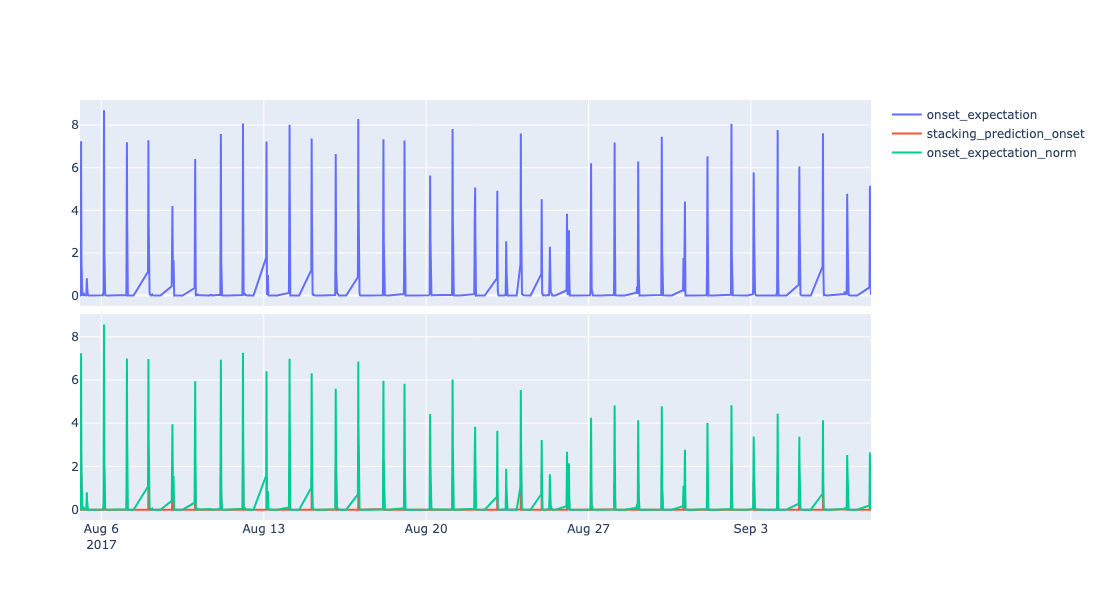

In [105]:

def post_process_from_2nd(
    pred_df,
    event_rate: int | float = 500,
    height: float = 0.001,
    event2col: dict[str, str] = {"onset": "stacking_prediction_onset", "wakeup": "stacking_prediction_wakeup"},
    event2offset: dict[str, str] = {"onset": "5h", "wakeup": "0h"},
    day_norm: bool = True,
    daily_score_offset=10,
    max_sub_later_date_rate=None,
):
    """
    1分ごとの予測値を用いてイベントを検出する
    用語
    - 予測地点: 2段目のモデルによって得られた1分毎の予測位置
    - 候補地点: event の候補となる 15秒 or 45秒始まりの30秒間隔の位置

    Args:
        pred_df (pl.DataFrame): timestamp 込み
        event_rate (int | float, optional): [0,1) の値であれば1分間に何回イベントが起こるか。intの場合はseries_idごとに同じイベント数を検出。 Defaults to 0.005.
        height (float, optional): 候補地点の期待値がこの値を下回ったら終了。 Defaults to 0.1.
        event2col (dict[str, str], optional): event名と予測値のカラム名の対応。 Defaults to {"onset": "stacking_prediction_onset", "wakeup": "stacking_prediction_wakeup"}.
        weight_rate (float | None, optional): 遠くの予測値の期待値を割り引く際の重み。Noneの場合は重みを1とする。1/weight_rate 倍ずつ遠くの予測値の重みが小さくなっていく。 Defaults to None.
        day_norm (bool, optional): 一日ごとに予測値を正規化するかどうか。 Defaults to False.
        daily_score_offset (float, optional): 正規化の際のoffset。 Defaults to 1.0.
    Returns:
        event_df (pl.DataFrame): row_id, series_id, step, event, score をカラムに持つ。
    """
    high_match_nums = (0, 1, 3, 5, 8, 10, 13, 15, 20, 25, 30)
    low_match_nums = (0, 1, 3, 5, 7, 10, 12, 15, 20, 25, 30)
    match_sums = np.ones(10)
    result_events_records = []

    # event ごとに処理
    for event, event_pred_col in event2col.items():
        """
        元の系列の予測地点(長さN): 0, 12, 24, 36, 48, 60, 72, 84, 96, 108, ..., (N-1)*12
        15秒から30秒おきのevent候補地点(長さ2N): 3, 9, 15, 21, 27, 33, 39, 45, 51, 57, ..., (N-1)*12+3, (N-1)*12+9
            - 15秒(3step)から1分おき(長さN): 3, 15, 27, 39, 51, 63, 75, 87, 99, 111, ..., (N-1)*12+3
                - 左の個数 {12: 1, 36: 3, 60: 5, 90: *8*, 120: 10, 150: *13*, 180: 15, 240: 20, 300: 25, 360: 30} high_match_nums
                - 右の個数 {12: 1, 36: 3, 60: 5, 90: *7*, 120: 10, 150: *12*, 180: 15, 240: 20, 300: 25, 360: 30} low_match_nums
            - 45秒(9step)から1分おき(長さN): 9, 21, 33, 45, 57, 69, 81, 93, 105, 117, ..., (N-1)*12+9
                - 左の個数 {12: 1, 36: 3, 60: 5, 90: *7*, 120: 10, 150: *12*, 180: 15, 240: 20, 300: 25, 360: 30} low_match_nums
                - 右の個数 {12: 1, 36: 3, 60: 5, 90: *8*, 120: 10, 150: *13*, 180: 15, 240: 20, 300: 25, 360: 30} high_match_nums       
        """

        # series内でのindexを振り、chunk内での最大と最小を計算
        minute_pred_df = pred_df

        if day_norm:
            minute_pred_df = minute_pred_df.with_columns(
                pl.col("timestamp").dt.offset_by(event2offset[event]).dt.date().alias("date")
            ).with_columns(
                pl.col(event_pred_col).sum().over(["series_id", "date"]).alias('date_sum')
            ).with_columns(
                pl.col(event_pred_col)/ (pl.col("date_sum") + (1/(daily_score_offset+pl.col("date_sum"))))
            )

        if max_sub_later_date_rate is not None:
            minute_pred_df = (
                minute_pred_df.with_columns(
                    pl.col("date").min().over("series_id").alias("min_date"),
                    pl.col("date").max().over("series_id").alias("max_date"),
                ).with_columns(                    
                    (
                        pl.lit(1.0)
                        - 
                        (pl.lit(max_sub_later_date_rate)
                            * (
                                (pl.col("date") - pl.col("min_date")).dt.days().cast(float)
                                / ((pl.col("max_date") - pl.col("min_date")).dt.days().cast(float) + 1.0)
                            )
                        )
                    ).alias('rate')
                ).with_columns(
                    pl.col(event_pred_col)
                    * pl.col('rate')
                )
            )

        max_event_per_series = event_rate if isinstance(event_rate, int) else int(len(minute_pred_df) * event_rate)

        # series_id, chunk_id, step でソート
        minute_pred_df = minute_pred_df.sort(["series_id", "chunk_id", "step"])

        # 1. 期待値の計算
        # 1.1 左側を計算 (同じindexの予測を含む左側を計算)
        """
        以下をそれぞれ計算する
        - 15秒(3step)から1分おき(長さN)での候補地点での期待値: stepは 3, 15, 27, 39, 51, 63, 75, 87, 99, 111, ..., (N-1)*12+3
        - 45秒(9step)から1分おき(長さN)での候補地点での期待値: stepは 9, 21, 33, 45, 57, 69, 81, 93, 105, 117, ..., (N-1)*12+9
        計算は左側の予測地点の数と、右側の予測地点の数
        """
        minute_pred_df = minute_pred_df.with_columns(
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        / match_sums[i]
                    )
                    for i, window in enumerate(high_match_nums[1:])
                ]
            ).alias(f"{event}_left_expectation_plus_3step"),
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        / match_sums[i]
                    )
                    for i, window in enumerate(low_match_nums[1:])
                ]
            ).alias(f"{event}_left_expectation_plus_9step"),
        )

        # 1.2 右側を計算(同じindexの予測を含まない右側を計算。逆順にして一個ずらしrolling_sumを取る必要がある）
        minute_pred_df = minute_pred_df.reverse()
        minute_pred_df = minute_pred_df.with_columns(
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .shift(1)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        .fill_null(0)
                        / match_sums[i]
                    )
                    for i, window in enumerate(low_match_nums[1:])
                ]
            ).alias(f"{event}_right_expectation_plus_3step"),
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .shift(1)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        .fill_null(0)
                        / match_sums[i]
                    )
                    for i, window in enumerate(high_match_nums[1:])
                ]
            ).alias(f"{event}_right_expectation_plus_9step"),
        )
        minute_pred_df = minute_pred_df.reverse()

        # 合計の期待値計算
        minute_pred_df = minute_pred_df.with_columns(
            (pl.col(f"{event}_left_expectation_plus_3step") + pl.col(f"{event}_right_expectation_plus_3step")).alias(
                f"{event}_expectation_sum_3step"
            ),
            (pl.col(f"{event}_left_expectation_plus_9step") + pl.col(f"{event}_right_expectation_plus_9step")).alias(
                f"{event}_expectation_sum_9step"
            ),
        )

        return minute_pred_df


# 一旦 series1つでのスコア計算テスト
"""
"efbfc4526d58"
"6ca4f4fca6a2"
"a88088855de5"
"3be2f86c3e45"
"e30cb792a2bc"
"18b61dd5aae8"
"e6ddbaaf0639"
"9a340507e36a"
"""
# テストのために一つのseriesに絞る
series_id = "fe90110788d2" #"99b829cbad2d"
series_df = pred_df.filter(pl.col('series_id')==series_id)
series_event_df = event_df.filter(pl.col('series_id')==series_id)

minute_pred_df_not_norm = post_process_from_2nd(
    series_df,
    max_sub_later_date_rate=None,
) 
minute_pred_df_not_norm = minute_pred_df_not_norm.to_pandas()


minute_pred_df = post_process_from_2nd(
    series_df,
    max_sub_later_date_rate=0.5
) 
minute_pred_df = minute_pred_df.to_pandas()


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas.tseries.offsets as offsets


fig = make_subplots(rows=2,
                    cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)
fig.update_layout(height=600)

fig.add_trace(go.Scatter(x=minute_pred_df_not_norm['timestamp'], 
                         y=minute_pred_df_not_norm['onset_expectation_sum_3step'], 
                         mode='lines',
                         name='onset_expectation'), row=1, col=1)
fig.add_trace(go.Scatter(x=minute_pred_df_not_norm['timestamp'], 
                         y=minute_pred_df_not_norm['stacking_prediction_onset']*5, 
                         mode='lines',
                         name='stacking_prediction_onset'), row=2, col=1)

fig.add_trace(go.Scatter(x=minute_pred_df['timestamp'], 
                         y=minute_pred_df['onset_expectation_sum_3step'], 
                         mode='lines',
                         name='onset_expectation_norm'), row=2, col=1)

fig.show()

In [106]:
minute_pred_df

series_id    step  stacking_prediction_onset  \
0      fe90110788d2    3144                   0.000035   
1      fe90110788d2    3156                   0.000029   
2      fe90110788d2    3168                   0.000023   
3      fe90110788d2    3180                   0.000019   
4      fe90110788d2    3192                   0.000024   
...             ...     ...                        ...   
18104  fe90110788d2  592488                        NaN   
18105  fe90110788d2  592500                        NaN   
18106  fe90110788d2  592512                        NaN   
18107  fe90110788d2  592524                        NaN   
18108  fe90110788d2  592536                        NaN   

       stacking_prediction_wakeup  chunk_id                 timestamp  \
0                        0.000007         0 2017-08-05 01:52:00+00:00   
1                        0.000005         0 2017-08-05 01:53:00+00:00   
2                        0.000005         0 2017-08-05 01:54:00+00:00   
3                        0.000005         0 2017-08-05 01:55:00+00:00   
4                        0.000006         0 2017-08-05 01:56:00+00:00   
...                           ...       ...                       ...   
18104                    0.000003       216                       NaT   
18105                    0.000003       216                       NaT   
18106                    0.000003       216                       NaT   
18107                    0.000003       216                       NaT   
18108                    0.000003       216                       NaT   

          anglez    enmo       date  date_sum   min_date   max_date  rate  \
0      36.575500  0.0205 2017-08-05  0.787112 2017-08-05 2017-09-08   1.0   
1      14.448300  0.0226 2017-08-05  0.787112 2017-08-05 2017-09-08   1.0   
2      18.497499  0.0006 2017-08-05  0.787112 2017-08-05 2017-09-08   1.0   
3      20.998699  0.0000 2017-08-05  0.787112 2017-08-05 2017-09-08   1.0   
4      17.789600  0.0193 2017-08-05  0.787112 2017-08-05 2017-09-08   1.0   
...          ...     ...        ...       ...        ...        ...   ...   
18104        NaN     NaN        NaT  0.000073 2017-08-05 2017-09-08   NaN   
18105        NaN     NaN        NaT  0.000073 2017-08-05 2017-09-08   NaN   
18106        NaN     NaN        NaT  0.000073 2017-08-05 2017-09-08   NaN   
18107        NaN     NaN        NaT  0.000073 2017-08-05 2017-09-08   NaN   
18108        NaN     NaN        NaT  0.000073 2017-08-05 2017-09-08   NaN   

       onset_left_expectation_plus_3step  onset_left_expectation_plus_9step  \
0                               0.000346                           0.000346   
1                               0.000601                           0.000601   
2                               0.000804                           0.000804   
3                               0.000939                           0.000939   
4                               0.001134                           0.001134   
...                                  ...                                ...   
18104                                NaN                                NaN   
18105                                NaN                                NaN   
18106                                NaN                                NaN   
18107                                NaN                                NaN   
18108                                NaN                                NaN   

       onset_right_expectation_plus_3step  onset_right_expectation_plus_9step  \
0                                0.004454                            0.004526   
1                                0.004605                            0.004693   
2                                0.004776                            0.004875   
3                                0.005075                            0.005159   
4                                0.005296                            0.005360   
...                                   ...                                 ..

## dayごとのステップ数に応じて normalize

In [31]:
import numpy as np
import polars as pl
from tqdm.auto import tqdm
from numba import jit



def post_process_from_2nd(
    pred_df,
    event_rate: int | float = 500,
    height: float = 0.001,
    event2col: dict[str, str] = {"onset": "stacking_prediction_onset", "wakeup": "stacking_prediction_wakeup"},
    event2offset: dict[str, str] = {"onset": "5h", "wakeup": "0h"},
    day_norm: bool = True,
    daily_score_offset=10,
):
    """
    1分ごとの予測値を用いてイベントを検出する
    用語
    - 予測地点: 2段目のモデルによって得られた1分毎の予測位置
    - 候補地点: event の候補となる 15秒 or 45秒始まりの30秒間隔の位置

    Args:
        pred_df (pl.DataFrame): timestamp 込み
        event_rate (int | float, optional): [0,1) の値であれば1分間に何回イベントが起こるか。intの場合はseries_idごとに同じイベント数を検出。 Defaults to 0.005.
        height (float, optional): 候補地点の期待値がこの値を下回ったら終了。 Defaults to 0.1.
        event2col (dict[str, str], optional): event名と予測値のカラム名の対応。 Defaults to {"onset": "stacking_prediction_onset", "wakeup": "stacking_prediction_wakeup"}.
        weight_rate (float | None, optional): 遠くの予測値の期待値を割り引く際の重み。Noneの場合は重みを1とする。1/weight_rate 倍ずつ遠くの予測値の重みが小さくなっていく。 Defaults to None.
        day_norm (bool, optional): 一日ごとに予測値を正規化するかどうか。 Defaults to False.
        daily_score_offset (float, optional): 正規化の際のoffset。 Defaults to 1.0.
    Returns:
        event_df (pl.DataFrame): row_id, series_id, step, event, score をカラムに持つ。
    """
    high_match_nums = (0, 1, 3, 5, 8, 10, 13, 15, 20, 25, 30)
    low_match_nums = (0, 1, 3, 5, 7, 10, 12, 15, 20, 25, 30)
    match_sums = np.ones(10)
    result_events_records = []

    # event ごとに処理
    for event, event_pred_col in event2col.items():
        """
        元の系列の予測地点(長さN): 0, 12, 24, 36, 48, 60, 72, 84, 96, 108, ..., (N-1)*12
        15秒から30秒おきのevent候補地点(長さ2N): 3, 9, 15, 21, 27, 33, 39, 45, 51, 57, ..., (N-1)*12+3, (N-1)*12+9
            - 15秒(3step)から1分おき(長さN): 3, 15, 27, 39, 51, 63, 75, 87, 99, 111, ..., (N-1)*12+3
                - 左の個数 {12: 1, 36: 3, 60: 5, 90: *8*, 120: 10, 150: *13*, 180: 15, 240: 20, 300: 25, 360: 30} high_match_nums
                - 右の個数 {12: 1, 36: 3, 60: 5, 90: *7*, 120: 10, 150: *12*, 180: 15, 240: 20, 300: 25, 360: 30} low_match_nums
            - 45秒(9step)から1分おき(長さN): 9, 21, 33, 45, 57, 69, 81, 93, 105, 117, ..., (N-1)*12+9
                - 左の個数 {12: 1, 36: 3, 60: 5, 90: *7*, 120: 10, 150: *12*, 180: 15, 240: 20, 300: 25, 360: 30} low_match_nums
                - 右の個数 {12: 1, 36: 3, 60: 5, 90: *8*, 120: 10, 150: *13*, 180: 15, 240: 20, 300: 25, 360: 30} high_match_nums       
        """

        # series内でのindexを振り、chunk内での最大と最小を計算
        minute_pred_df = pred_df

        if day_norm:
            minute_pred_df = minute_pred_df.with_columns(
                pl.col("timestamp").dt.offset_by(event2offset[event]).dt.date().alias("date")
            ).with_columns(
                pl.col(event_pred_col).mean().over(["series_id", "date"]).alias('date_mean') * 1000
            ).with_columns(
                pl.col(event_pred_col)/ (pl.col("date_mean") + (1/(daily_score_offset+pl.col("date_mean"))))
            )


        max_event_per_series = event_rate if isinstance(event_rate, int) else int(len(minute_pred_df) * event_rate)

        # series_id, chunk_id, step でソート
        minute_pred_df = minute_pred_df.sort(["series_id", "chunk_id", "step"])

        # 1. 期待値の計算
        # 1.1 左側を計算 (同じindexの予測を含む左側を計算)
        """
        以下をそれぞれ計算する
        - 15秒(3step)から1分おき(長さN)での候補地点での期待値: stepは 3, 15, 27, 39, 51, 63, 75, 87, 99, 111, ..., (N-1)*12+3
        - 45秒(9step)から1分おき(長さN)での候補地点での期待値: stepは 9, 21, 33, 45, 57, 69, 81, 93, 105, 117, ..., (N-1)*12+9
        計算は左側の予測地点の数と、右側の予測地点の数
        """
        minute_pred_df = minute_pred_df.with_columns(
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        / match_sums[i]
                    )
                    for i, window in enumerate(high_match_nums[1:])
                ]
            ).alias(f"{event}_left_expectation_plus_3step"),
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        / match_sums[i]
                    )
                    for i, window in enumerate(low_match_nums[1:])
                ]
            ).alias(f"{event}_left_expectation_plus_9step"),
        )

        # 1.2 右側を計算(同じindexの予測を含まない右側を計算。逆順にして一個ずらしrolling_sumを取る必要がある）
        minute_pred_df = minute_pred_df.reverse()
        minute_pred_df = minute_pred_df.with_columns(
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .shift(1)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        .fill_null(0)
                        / match_sums[i]
                    )
                    for i, window in enumerate(low_match_nums[1:])
                ]
            ).alias(f"{event}_right_expectation_plus_3step"),
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .shift(1)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        .fill_null(0)
                        / match_sums[i]
                    )
                    for i, window in enumerate(high_match_nums[1:])
                ]
            ).alias(f"{event}_right_expectation_plus_9step"),
        )
        minute_pred_df = minute_pred_df.reverse()

        # 合計の期待値計算
        minute_pred_df = minute_pred_df.with_columns(
            (pl.col(f"{event}_left_expectation_plus_3step") + pl.col(f"{event}_right_expectation_plus_3step")).alias(
                f"{event}_expectation_sum_3step"
            ),
            (pl.col(f"{event}_left_expectation_plus_9step") + pl.col(f"{event}_right_expectation_plus_9step")).alias(
                f"{event}_expectation_sum_9step"
            ),
        )

        # print(display(minute_pred_df))

        # 3. 最大値の取得 & 期待値の割引
        """
        各予測地点の power を管理する。powerは以下の11種類
        0: その予測地点が影響を与える範囲は無い
        1: その予測地点が影響を与える範囲は左右1つ(1min)
        2: その予測地点が影響を与える範囲は左右3つ
        ︙
        10: 左右30(step 0~360)

        event を作るたびに、eventからtolerance内にある予測地点のpowerを下げる。
        その際に予測地点からtolerance内にある、eventがあったところも含めた候補地点の期待値を割り引く。
        """
        for series_id, series_df in tqdm(
            minute_pred_df.select(
                [
                    "series_id",
                    "chunk_id",
                    "step",
                    event_pred_col,
                    f"{event}_expectation_sum_3step",
                    f"{event}_expectation_sum_9step",
                ]
            ).group_by("series_id"),
            desc=f"detect {event} peaks",
            leave=False,
            total=len(minute_pred_df["series_id"].unique()),
        ):
            # chunkごとの id の最大最小を計算
            series_df = series_df.with_row_count().with_columns(
                pl.col("row_nr").max().over(["chunk_id"]).alias("max_id_in_chunk"),
                pl.col("row_nr").min().over(["chunk_id"]).alias("min_id_in_chunk"),
            )

            preds = series_df[event_pred_col].to_numpy()
            expectation_sum_3step = series_df[f"{event}_expectation_sum_3step"].to_numpy(writable=True)
            expectation_sum_9step = series_df[f"{event}_expectation_sum_9step"].to_numpy(writable=True)
            steps = series_df[f"step"].to_numpy(writable=True)
            step_id_mins = series_df["min_id_in_chunk"].to_numpy(writable=True)
            step_id_maxs = series_df["max_id_in_chunk"].to_numpy(writable=True) + 1
            powers = np.ones(len(expectation_sum_3step), dtype=np.int32) * 10

            result_steps, result_scores = detect_events_for_serie(
                height,
                max_event_per_series,
                high_match_nums,
                low_match_nums,
                match_sums,
                steps,
                step_id_mins,
                step_id_maxs,
                preds,
                expectation_sum_3step,
                expectation_sum_9step,
                powers,
            )

            for i in range(len(result_steps)):
                result_events_records.append(
                    {
                        "series_id": series_id,
                        "step": result_steps[i],
                        "event": event,
                        "score": result_scores[i],
                    }
                )

            # print(expectation_sum_3step[max_step_index], expectation_sum_9step[max_step_index])

    if len(result_events_records) == 0:  # 一つも予測がない場合はdummyを入れる
        result_events_records.append(
            {
                "series_id": series_id,
                "step": 0,
                "event": "onset",
                "score": 0,
            }
        )
    sub_df = pl.DataFrame(result_events_records).sort(by=["series_id", "step"])
    row_ids = pl.Series(name="row_id", values=np.arange(len(sub_df)))
    sub_df = sub_df.with_columns(row_ids).select(["row_id", "series_id", "step", "event", "score"])
    return sub_df


@jit(nopython=True, cache=True)
def detect_events_for_serie(
    height,
    max_event_per_series,
    high_match_nums,
    low_match_nums,
    match_sums,
    steps,
    step_id_mins,
    step_id_maxs,
    preds,
    expectation_sum_3step,
    expectation_sum_9step,
    powers,
):
    result_steps = []
    result_scores = []
    for _ in range(max_event_per_series):  # 高い順に最大max_event_per_series個のeventを決定
        # 3.1 最大値の取得
        # 合計の期待値が最大のstepを取得
        max_step3 = expectation_sum_3step.argmax()
        max_score3 = expectation_sum_3step[max_step3]
        max_step9 = expectation_sum_9step.argmax()
        max_score9 = expectation_sum_9step[max_step9]
        if max_score3 > max_score9:
            # print('max_score3')
            left_nums = high_match_nums
            right_nums = low_match_nums
            max_step_index = max_step3
            max_score = max_score3
            if max_score < height:  # 閾値以下なら終了
                break
            result_steps.append(steps[max_step_index] + 3)
            result_scores.append(max_score)
        else:
            # print('max_score9')
            left_nums = low_match_nums
            right_nums = high_match_nums
            max_step_index = max_step9
            max_score = max_score9
            if max_score < height:  # 閾値以下なら終了
                break
            result_steps.append(steps[max_step_index] + 9)
            result_scores.append(max_score)
        # print(f"max_step_index:{max_step_index}, max_score:{max_score}")

        # 3.2 期待値の割引
        """
        各予測地点のpowerを修正するとともに、候補地点の期待値を割引く。
        powerが pi まで小さくなることによってその予測値が影響を与える範囲が狭くなる。
        つまり狭くなって範囲から抜けた expectation_sum の値が、その予測値の値*重みの分だけ小さくなる
        """
        # 3.2.1 まずはpowerを修正するstepの候補を探す
        target_step_powers = []  # (target_step, pred, base_power, power, step_min, step_max)のリスト
        for pi in range(0, 10):
            # 左側
            for l_diff in range(left_nums[pi], left_nums[pi + 1]):
                target_step_index = max_step_index - l_diff
                if target_step_index < 0:
                    break
                pred = preds[target_step_index]
                base_power = powers[target_step_index]
                if base_power > pi:  # power が小さくなる場合のみ修正
                    target_step_powers.append(
                        (
                            target_step_index,
                            pred,
                            base_power,
                            pi,
                            step_id_mins[target_step_index],
                            step_id_maxs[target_step_index],
                        )
                    )
            # 右側
            for r_diff in range(right_nums[pi] + 1, right_nums[pi + 1] + 1):  # 自分自身と同じindexは含めない
                target_step_index = max_step_index + r_diff
                if target_step_index >= len(powers):
                    break
                pred = preds[target_step_index]
                base_power = powers[target_step_index]
                if base_power > pi:
                    target_step_powers.append(
                        (
                            target_step_index,
                            pred,
                            base_power,
                            pi,
                            step_id_mins[target_step_index],
                            step_id_maxs[target_step_index],
                        )
                    )
        # print('target_step_powers', target_step_powers)

        # 3.2.2 対象となる step の power を修正するとともに期待値を割り引く
        """
        予測地点のpowerを下げるとともに、関連する候補地点の期待値を修正する。
        検出したeventから遠い予測地点の場合は、予測地点に近い候補地点であっても期待値はその分割り引かれる。
        3stepの修正をする時は target_stepから左側が low_match_nums, 右側が high_match_nums
        9stepの修正をする時は target_stepから左側が high_match_nums, 右側が low_match_nums
        だんだんと内側のみがのこるように修正する。

        - powerが 10 → 8 になるケースは左右1~30個に影響を及ぼしていたものが、左右の1~20個に影響を及ぼすようになる。また、powerが2個減った分全体の期待値も割り引かれる
        - powerが 10 → 5 になるケースは左右1~30個に影響を及ぼしていたものが、左右の1~12(13)個に影響を及ぼすようになる
        - powerが 8 → 7 になるケースは左右1~20個に影響を及ぼしていたものが、左右の1~15個に影響を及ぼすようになる
        """
        for si, pred, base_power, power, step_min, step_max in target_step_powers:
            # print(f"si:{si}, pred:{pred}, base_power:{base_power}, power:{power}")
            powers[si] = power
            # 中心ほど重みが強いので power ごとに処理
            for pi in range(base_power, power, -1):  # base_powerからpowerに減らしていくことで予測値の外側から削る
                # 3step
                left_diff_max = low_match_nums[pi]
                right_diff_max = high_match_nums[pi]
                expectation_sum_3step[max(si - left_diff_max, step_min) : min(si + right_diff_max, step_max)] -= (
                    pred / match_sums[pi - 1]
                )
                """
                if ((si-left_diff_max <= max_step_index) and (max_step_index < si+right_diff_max)):
                    print(f'3step pi:{pi}')
                    print(f"max_step_index:{max_step_index}, si:{si}, left_diff_max:{left_diff_max}, right_diff_max:{right_diff_max}") 
                    print("[", si-left_diff_max, si+right_diff_max, ")")
                    print(f"power: {pi}→{pi-1}, pred:{pred}")
                    print()
                """
                # 9step
                left_diff_max = high_match_nums[pi]
                right_diff_max = low_match_nums[pi]
                expectation_sum_9step[max(si - left_diff_max, step_min) : min(si + right_diff_max, step_max)] -= (
                    pred / match_sums[pi - 1]
                )
                """
                if ((si-left_diff_max <= max_step_index) and (max_step_index < si+right_diff_max)):
                    print(f'9step pi:{pi}')
                    print(f"max_step_index:{max_step_index}, si:{si}, left_diff_max:{left_diff_max}, right_diff_max:{right_diff_max}") 
                    print("[", si-left_diff_max, si+right_diff_max, ")")
                    print(f"power: {pi}→{pi-1}, pred:{pred}")
                    print()
                """
    return result_steps, result_scores


In [42]:
# 一旦 series1つでのスコア計算テスト
"""
"efbfc4526d58"
"6ca4f4fca6a2"
"a88088855de5"
"3be2f86c3e45"
"e30cb792a2bc"
"18b61dd5aae8"
"e6ddbaaf0639"
"9a340507e36a"
"""
# テストのために一つのseriesに絞る
series_id = "efbfc4526d58" #"99b829cbad2d"
series_df = pred_df.filter(pl.col('series_id')==series_id)
series_event_df = event_df.filter(pl.col('series_id')==series_id)

"""
series_df=series_df.with_columns(
    pl.lit(1.0, dtype=pl.Float32).alias('prediction_onset')
)
"""

display(series_event_df.head())


sub_df = post_process_from_2nd(
    series_df,
    daily_score_offset=5
) 

        
score = event_detection_ap(
    series_event_df.to_pandas(),
    sub_df.to_pandas(),
)

print(score)

display(sub_df.head())
print(len(sub_df))

shape: (5, 5)
┌──────────────┬───────┬────────┬───────┬─────────────────────────┐
│ series_id    ┆ night ┆ event  ┆ step  ┆ timestamp               │
│ ---          ┆ ---   ┆ ---    ┆ ---   ┆ ---                     │
│ str          ┆ i64   ┆ str    ┆ i64   ┆ datetime[μs, UTC]       │
╞══════════════╪═══════╪════════╪═══════╪═════════════════════════╡
│ efbfc4526d58 ┆ 1     ┆ onset  ┆ 8136  ┆ 2018-12-15 08:33:00 UTC │
│ efbfc4526d58 ┆ 1     ┆ wakeup ┆ 13092 ┆ 2018-12-15 15:26:00 UTC │
│ efbfc4526d58 ┆ 2     ┆ onset  ┆ 24612 ┆ 2018-12-16 07:26:00 UTC │
│ efbfc4526d58 ┆ 2     ┆ wakeup ┆ 30012 ┆ 2018-12-16 14:56:00 UTC │
│ efbfc4526d58 ┆ 3     ┆ onset  ┆ 41616 ┆ 2018-12-17 07:03:00 UTC │
└──────────────┴───────┴────────┴───────┴─────────────────────────┘

detect onset peaks:   0%|          | 0/1 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/1 [00:00<?, ?it/s]

Matching detections to ground truth events:   0%|          | 0/2 [00:00<?, ?it/s]

0.7010984701832601


shape: (5, 5)
┌────────┬──────────────┬──────┬────────┬──────────┐
│ row_id ┆ series_id    ┆ step ┆ event  ┆ score    │
│ ---    ┆ ---          ┆ ---  ┆ ---    ┆ ---      │
│ i64    ┆ str          ┆ i64  ┆ str    ┆ f64      │
╞════════╪══════════════╪══════╪════════╪══════════╡
│ 0      ┆ efbfc4526d58 ┆ 363  ┆ wakeup ┆ 0.002253 │
│ 1      ┆ efbfc4526d58 ┆ 459  ┆ wakeup ┆ 0.025822 │
│ 2      ┆ efbfc4526d58 ┆ 579  ┆ wakeup ┆ 0.001644 │
│ 3      ┆ efbfc4526d58 ┆ 8019 ┆ onset  ┆ 0.002195 │
│ 4      ┆ efbfc4526d58 ┆ 8103 ┆ onset  ┆ 0.009244 │
└────────┴──────────────┴──────┴────────┴──────────┘

261


In [41]:
with trace('process'):
    sub_df = post_process_from_2nd(
        pred_df,
        daily_score_offset=1
    )
    print(len(sub_df))


with trace('event detection ap'):
    score, table = event_detection_ap(
        event_df.to_pandas(),
        sub_df.to_pandas(),
        with_table=True
    )
    print(score)


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

198958


[3.7GB(+0.2GB):21.9sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.7735306164231945


[3.5GB(-0.2GB):8.1sec] event detection ap 


In [ ]:
for event_offset in [i for i in range(24)]:
    print(event_offset)
    with trace('process'):
        sub_df = post_process_from_2nd(
            pred_df,
            event_rate=500,
            height = 0.001,
            weight_rate=1.0,
            day_norm=True,
            daily_score_offset=10,
            event2offset = {"onset": f"{event_offset}h", "wakeup": "0h"}
        )
        print(len(sub_df))


    with trace('event detection ap'):
        score = event_detection_ap(
            event_df.to_pandas(),
            sub_df.to_pandas(),
        )
        print(score)


## 不要な引数を削除

In [21]:
import numpy as np
import polars as pl
from tqdm.auto import tqdm
from numba import jit



def post_process_from_2nd(
    pred_df,
    event_rate: int | float = 500,
    height: float = 0.001,
    event2col: dict[str, str] = {"onset": "stacking_prediction_onset", "wakeup": "stacking_prediction_wakeup"},
    event2offset: dict[str, str] = {"onset": "5h", "wakeup": "0h"},
    day_norm: bool = True,
    daily_score_offset=10,
):
    """
    1分ごとの予測値を用いてイベントを検出する
    用語
    - 予測地点: 2段目のモデルによって得られた1分毎の予測位置
    - 候補地点: event の候補となる 15秒 or 45秒始まりの30秒間隔の位置

    Args:
        pred_df (pl.DataFrame): timestamp 込み
        event_rate (int | float, optional): [0,1) の値であれば1分間に何回イベントが起こるか。intの場合はseries_idごとに同じイベント数を検出。 Defaults to 0.005.
        height (float, optional): 候補地点の期待値がこの値を下回ったら終了。 Defaults to 0.1.
        event2col (dict[str, str], optional): event名と予測値のカラム名の対応。 Defaults to {"onset": "stacking_prediction_onset", "wakeup": "stacking_prediction_wakeup"}.
        weight_rate (float | None, optional): 遠くの予測値の期待値を割り引く際の重み。Noneの場合は重みを1とする。1/weight_rate 倍ずつ遠くの予測値の重みが小さくなっていく。 Defaults to None.
        day_norm (bool, optional): 一日ごとに予測値を正規化するかどうか。 Defaults to False.
        daily_score_offset (float, optional): 正規化の際のoffset。 Defaults to 1.0.
    Returns:
        event_df (pl.DataFrame): row_id, series_id, step, event, score をカラムに持つ。
    """
    high_match_nums = (0, 1, 3, 5, 8, 10, 13, 15, 20, 25, 30)
    low_match_nums = (0, 1, 3, 5, 7, 10, 12, 15, 20, 25, 30)
    match_sums = np.ones(10)
    result_events_records = []

    # event ごとに処理
    for event, event_pred_col in event2col.items():
        """
        元の系列の予測地点(長さN): 0, 12, 24, 36, 48, 60, 72, 84, 96, 108, ..., (N-1)*12
        15秒から30秒おきのevent候補地点(長さ2N): 3, 9, 15, 21, 27, 33, 39, 45, 51, 57, ..., (N-1)*12+3, (N-1)*12+9
            - 15秒(3step)から1分おき(長さN): 3, 15, 27, 39, 51, 63, 75, 87, 99, 111, ..., (N-1)*12+3
                - 左の個数 {12: 1, 36: 3, 60: 5, 90: *8*, 120: 10, 150: *13*, 180: 15, 240: 20, 300: 25, 360: 30} high_match_nums
                - 右の個数 {12: 1, 36: 3, 60: 5, 90: *7*, 120: 10, 150: *12*, 180: 15, 240: 20, 300: 25, 360: 30} low_match_nums
            - 45秒(9step)から1分おき(長さN): 9, 21, 33, 45, 57, 69, 81, 93, 105, 117, ..., (N-1)*12+9
                - 左の個数 {12: 1, 36: 3, 60: 5, 90: *7*, 120: 10, 150: *12*, 180: 15, 240: 20, 300: 25, 360: 30} low_match_nums
                - 右の個数 {12: 1, 36: 3, 60: 5, 90: *8*, 120: 10, 150: *13*, 180: 15, 240: 20, 300: 25, 360: 30} high_match_nums       
        """

        # series内でのindexを振り、chunk内での最大と最小を計算
        minute_pred_df = pred_df

        if day_norm:
            minute_pred_df = minute_pred_df.with_columns(
                pl.col("timestamp").dt.offset_by(event2offset[event]).dt.date().alias("date")
            ).with_columns(
                pl.col(event_pred_col).sum().over(["series_id", "date"]).alias('date_sum')
            ).with_columns(
                pl.col(event_pred_col)/ (pl.col("date_sum") + (1/(daily_score_offset+pl.col("date_sum"))))
            )


        max_event_per_series = event_rate if isinstance(event_rate, int) else int(len(minute_pred_df) * event_rate)

        # series_id, chunk_id, step でソート
        minute_pred_df = minute_pred_df.sort(["series_id", "chunk_id", "step"])

        # 1. 期待値の計算
        # 1.1 左側を計算 (同じindexの予測を含む左側を計算)
        """
        以下をそれぞれ計算する
        - 15秒(3step)から1分おき(長さN)での候補地点での期待値: stepは 3, 15, 27, 39, 51, 63, 75, 87, 99, 111, ..., (N-1)*12+3
        - 45秒(9step)から1分おき(長さN)での候補地点での期待値: stepは 9, 21, 33, 45, 57, 69, 81, 93, 105, 117, ..., (N-1)*12+9
        計算は左側の予測地点の数と、右側の予測地点の数
        """
        minute_pred_df = minute_pred_df.with_columns(
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        / match_sums[i]
                    )
                    for i, window in enumerate(high_match_nums[1:])
                ]
            ).alias(f"{event}_left_expectation_plus_3step"),
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        / match_sums[i]
                    )
                    for i, window in enumerate(low_match_nums[1:])
                ]
            ).alias(f"{event}_left_expectation_plus_9step"),
        )

        # 1.2 右側を計算(同じindexの予測を含まない右側を計算。逆順にして一個ずらしrolling_sumを取る必要がある）
        minute_pred_df = minute_pred_df.reverse()
        minute_pred_df = minute_pred_df.with_columns(
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .shift(1)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        .fill_null(0)
                        / match_sums[i]
                    )
                    for i, window in enumerate(low_match_nums[1:])
                ]
            ).alias(f"{event}_right_expectation_plus_3step"),
            pl.sum_horizontal(
                [
                    (
                        pl.col(event_pred_col)
                        .shift(1)
                        .rolling_sum(window_size=window, center=False, min_periods=1)
                        .over(["series_id", "chunk_id"])
                        .fill_null(0)
                        / match_sums[i]
                    )
                    for i, window in enumerate(high_match_nums[1:])
                ]
            ).alias(f"{event}_right_expectation_plus_9step"),
        )
        minute_pred_df = minute_pred_df.reverse()

        # 合計の期待値計算
        minute_pred_df = minute_pred_df.with_columns(
            (pl.col(f"{event}_left_expectation_plus_3step") + pl.col(f"{event}_right_expectation_plus_3step")).alias(
                f"{event}_expectation_sum_3step"
            ),
            (pl.col(f"{event}_left_expectation_plus_9step") + pl.col(f"{event}_right_expectation_plus_9step")).alias(
                f"{event}_expectation_sum_9step"
            ),
        )

        # print(display(minute_pred_df))

        # 3. 最大値の取得 & 期待値の割引
        """
        各予測地点の power を管理する。powerは以下の11種類
        0: その予測地点が影響を与える範囲は無い
        1: その予測地点が影響を与える範囲は左右1つ(1min)
        2: その予測地点が影響を与える範囲は左右3つ
        ︙
        10: 左右30(step 0~360)

        event を作るたびに、eventからtolerance内にある予測地点のpowerを下げる。
        その際に予測地点からtolerance内にある、eventがあったところも含めた候補地点の期待値を割り引く。
        """
        for series_id, series_df in tqdm(
            minute_pred_df.select(
                [
                    "series_id",
                    "chunk_id",
                    "step",
                    event_pred_col,
                    f"{event}_expectation_sum_3step",
                    f"{event}_expectation_sum_9step",
                ]
            ).group_by("series_id"),
            desc=f"detect {event} peaks",
            leave=False,
            total=len(minute_pred_df["series_id"].unique()),
        ):
            # chunkごとの id の最大最小を計算
            series_df = series_df.with_row_count().with_columns(
                pl.col("row_nr").max().over(["chunk_id"]).alias("max_id_in_chunk"),
                pl.col("row_nr").min().over(["chunk_id"]).alias("min_id_in_chunk"),
            )

            preds = series_df[event_pred_col].to_numpy()
            expectation_sum_3step = series_df[f"{event}_expectation_sum_3step"].to_numpy(writable=True)
            expectation_sum_9step = series_df[f"{event}_expectation_sum_9step"].to_numpy(writable=True)
            steps = series_df[f"step"].to_numpy(writable=True)
            step_id_mins = series_df["min_id_in_chunk"].to_numpy(writable=True)
            step_id_maxs = series_df["max_id_in_chunk"].to_numpy(writable=True) + 1
            powers = np.ones(len(expectation_sum_3step), dtype=np.int32) * 10

            result_steps, result_scores = detect_events_for_serie(
                height,
                max_event_per_series,
                high_match_nums,
                low_match_nums,
                match_sums,
                steps,
                step_id_mins,
                step_id_maxs,
                preds,
                expectation_sum_3step,
                expectation_sum_9step,
                powers,
            )

            for i in range(len(result_steps)):
                result_events_records.append(
                    {
                        "series_id": series_id,
                        "step": result_steps[i],
                        "event": event,
                        "score": result_scores[i],
                    }
                )

            # print(expectation_sum_3step[max_step_index], expectation_sum_9step[max_step_index])

    if len(result_events_records) == 0:  # 一つも予測がない場合はdummyを入れる
        result_events_records.append(
            {
                "series_id": series_id,
                "step": 0,
                "event": "onset",
                "score": 0,
            }
        )
    sub_df = pl.DataFrame(result_events_records).sort(by=["series_id", "step"])
    row_ids = pl.Series(name="row_id", values=np.arange(len(sub_df)))
    sub_df = sub_df.with_columns(row_ids).select(["row_id", "series_id", "step", "event", "score"])
    return sub_df


@jit(nopython=True, cache=True)
def detect_events_for_serie(
    height,
    max_event_per_series,
    high_match_nums,
    low_match_nums,
    match_sums,
    steps,
    step_id_mins,
    step_id_maxs,
    preds,
    expectation_sum_3step,
    expectation_sum_9step,
    powers,
):
    result_steps = []
    result_scores = []
    for _ in range(max_event_per_series):  # 高い順に最大max_event_per_series個のeventを決定
        # 3.1 最大値の取得
        # 合計の期待値が最大のstepを取得
        max_step3 = expectation_sum_3step.argmax()
        max_score3 = expectation_sum_3step[max_step3]
        max_step9 = expectation_sum_9step.argmax()
        max_score9 = expectation_sum_9step[max_step9]
        if max_score3 > max_score9:
            # print('max_score3')
            left_nums = high_match_nums
            right_nums = low_match_nums
            max_step_index = max_step3
            max_score = max_score3
            if max_score < height:  # 閾値以下なら終了
                break
            result_steps.append(steps[max_step_index] + 3)
            result_scores.append(max_score)
        else:
            # print('max_score9')
            left_nums = low_match_nums
            right_nums = high_match_nums
            max_step_index = max_step9
            max_score = max_score9
            if max_score < height:  # 閾値以下なら終了
                break
            result_steps.append(steps[max_step_index] + 9)
            result_scores.append(max_score)
        # print(f"max_step_index:{max_step_index}, max_score:{max_score}")

        # 3.2 期待値の割引
        """
        各予測地点のpowerを修正するとともに、候補地点の期待値を割引く。
        powerが pi まで小さくなることによってその予測値が影響を与える範囲が狭くなる。
        つまり狭くなって範囲から抜けた expectation_sum の値が、その予測値の値*重みの分だけ小さくなる
        """
        # 3.2.1 まずはpowerを修正するstepの候補を探す
        target_step_powers = []  # (target_step, pred, base_power, power, step_min, step_max)のリスト
        for pi in range(0, 10):
            # 左側
            for l_diff in range(left_nums[pi], left_nums[pi + 1]):
                target_step_index = max_step_index - l_diff
                if target_step_index < 0:
                    break
                pred = preds[target_step_index]
                base_power = powers[target_step_index]
                if base_power > pi:  # power が小さくなる場合のみ修正
                    target_step_powers.append(
                        (
                            target_step_index,
                            pred,
                            base_power,
                            pi,
                            step_id_mins[target_step_index],
                            step_id_maxs[target_step_index],
                        )
                    )
            # 右側
            for r_diff in range(right_nums[pi] + 1, right_nums[pi + 1] + 1):  # 自分自身と同じindexは含めない
                target_step_index = max_step_index + r_diff
                if target_step_index >= len(powers):
                    break
                pred = preds[target_step_index]
                base_power = powers[target_step_index]
                if base_power > pi:
                    target_step_powers.append(
                        (
                            target_step_index,
                            pred,
                            base_power,
                            pi,
                            step_id_mins[target_step_index],
                            step_id_maxs[target_step_index],
                        )
                    )
        # print('target_step_powers', target_step_powers)

        # 3.2.2 対象となる step の power を修正するとともに期待値を割り引く
        """
        予測地点のpowerを下げるとともに、関連する候補地点の期待値を修正する。
        検出したeventから遠い予測地点の場合は、予測地点に近い候補地点であっても期待値はその分割り引かれる。
        3stepの修正をする時は target_stepから左側が low_match_nums, 右側が high_match_nums
        9stepの修正をする時は target_stepから左側が high_match_nums, 右側が low_match_nums
        だんだんと内側のみがのこるように修正する。

        - powerが 10 → 8 になるケースは左右1~30個に影響を及ぼしていたものが、左右の1~20個に影響を及ぼすようになる。また、powerが2個減った分全体の期待値も割り引かれる
        - powerが 10 → 5 になるケースは左右1~30個に影響を及ぼしていたものが、左右の1~12(13)個に影響を及ぼすようになる
        - powerが 8 → 7 になるケースは左右1~20個に影響を及ぼしていたものが、左右の1~15個に影響を及ぼすようになる
        """
        for si, pred, base_power, power, step_min, step_max in target_step_powers:
            # print(f"si:{si}, pred:{pred}, base_power:{base_power}, power:{power}")
            powers[si] = power
            # 中心ほど重みが強いので power ごとに処理
            for pi in range(base_power, power, -1):  # base_powerからpowerに減らしていくことで予測値の外側から削る
                # 3step
                left_diff_max = low_match_nums[pi]
                right_diff_max = high_match_nums[pi]
                expectation_sum_3step[max(si - left_diff_max, step_min) : min(si + right_diff_max, step_max)] -= (
                    pred / match_sums[pi - 1]
                )
                """
                if ((si-left_diff_max <= max_step_index) and (max_step_index < si+right_diff_max)):
                    print(f'3step pi:{pi}')
                    print(f"max_step_index:{max_step_index}, si:{si}, left_diff_max:{left_diff_max}, right_diff_max:{right_diff_max}") 
                    print("[", si-left_diff_max, si+right_diff_max, ")")
                    print(f"power: {pi}→{pi-1}, pred:{pred}")
                    print()
                """
                # 9step
                left_diff_max = high_match_nums[pi]
                right_diff_max = low_match_nums[pi]
                expectation_sum_9step[max(si - left_diff_max, step_min) : min(si + right_diff_max, step_max)] -= (
                    pred / match_sums[pi - 1]
                )
                """
                if ((si-left_diff_max <= max_step_index) and (max_step_index < si+right_diff_max)):
                    print(f'9step pi:{pi}')
                    print(f"max_step_index:{max_step_index}, si:{si}, left_diff_max:{left_diff_max}, right_diff_max:{right_diff_max}") 
                    print("[", si-left_diff_max, si+right_diff_max, ")")
                    print(f"power: {pi}→{pi-1}, pred:{pred}")
                    print()
                """
    return result_steps, result_scores


In [11]:
with trace('process'):
    sub_df = post_process_from_2nd(
        pred_df,
        event_rate=500,
        height = 0.001,
    )
    print(len(sub_df))


with trace('event detection ap'):
    score, table = event_detection_ap(
        event_df.to_pandas(),
        sub_df.to_pandas(),
        with_table=True
    )
    print(score)


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

250049


[3.5GB(+0.3GB):21.0sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8338145511347304


[3.4GB(-0.1GB):9.2sec] event detection ap 


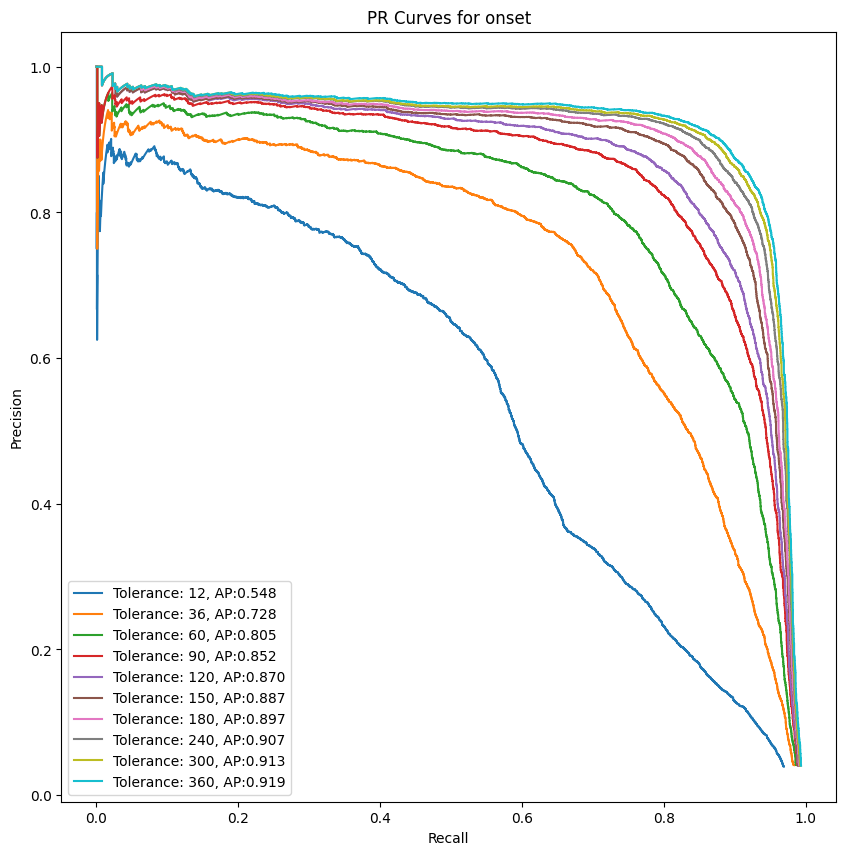

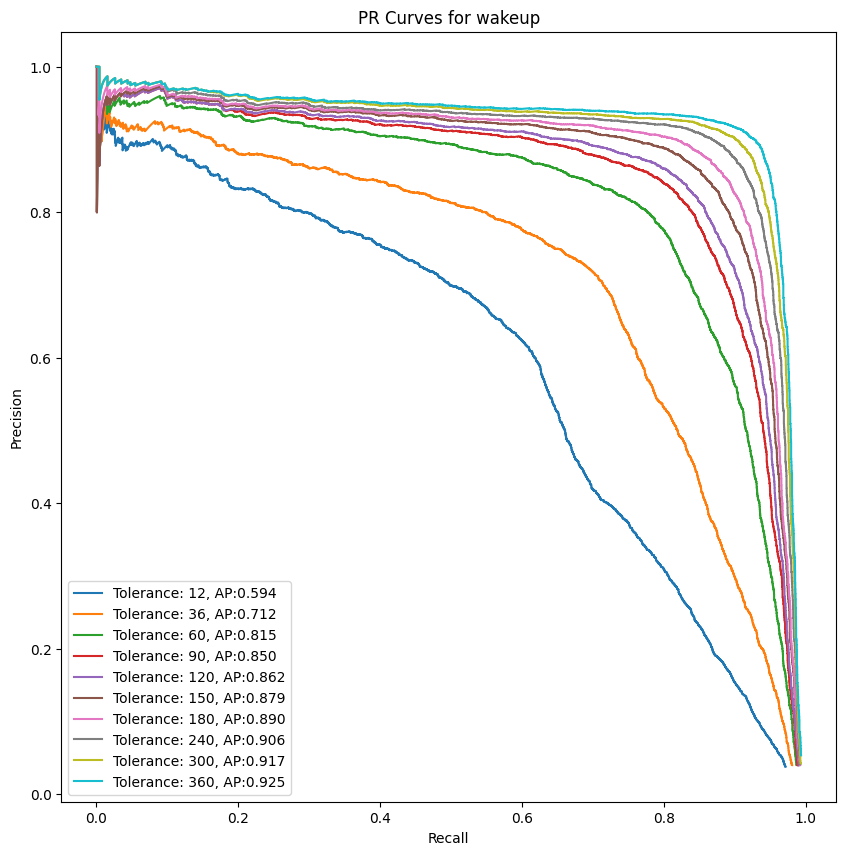

In [12]:
import matplotlib.pyplot as plt
for event in ["onset", "wakeup"]:
    plt.figure(figsize=(10, 10))
    for (event_key, tolerance), group in table[table.index.get_level_values("event") == event].iterrows():
        plt.plot(
            group["recall"][:-1], group["precision"][:-1], label=f'Tolerance: {tolerance}, AP:{group["ap"]:.3f}'
        )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curves for {event}")
    plt.legend()
    plt.show()

In [13]:
with trace('process'):
    sub_df = post_process_from_2nd(
        pred_df,
        event_rate=500,
        height = 0.001,
        day_norm=False
    )
    print(len(sub_df))


with trace('event detection ap'):
    score, table = event_detection_ap(
        event_df.to_pandas(),
        sub_df.to_pandas(),
        with_table=True
    )
    print(score)


detect onset peaks:   0%|          | 0/277 [00:00<?, ?it/s]

detect wakeup peaks:   0%|          | 0/277 [00:00<?, ?it/s]

236758


[3.7GB(+0.3GB):22.4sec] process 


Matching detections to ground truth events:   0%|          | 0/538 [00:00<?, ?it/s]

0.8121662736068568


[3.5GB(-0.2GB):8.6sec] event detection ap 


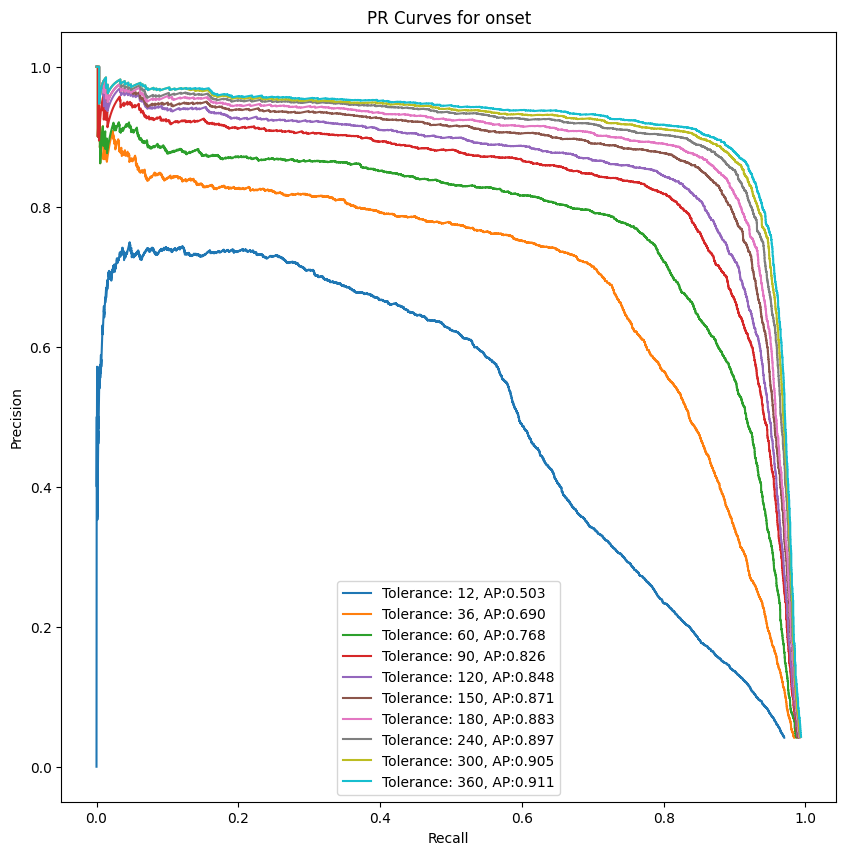

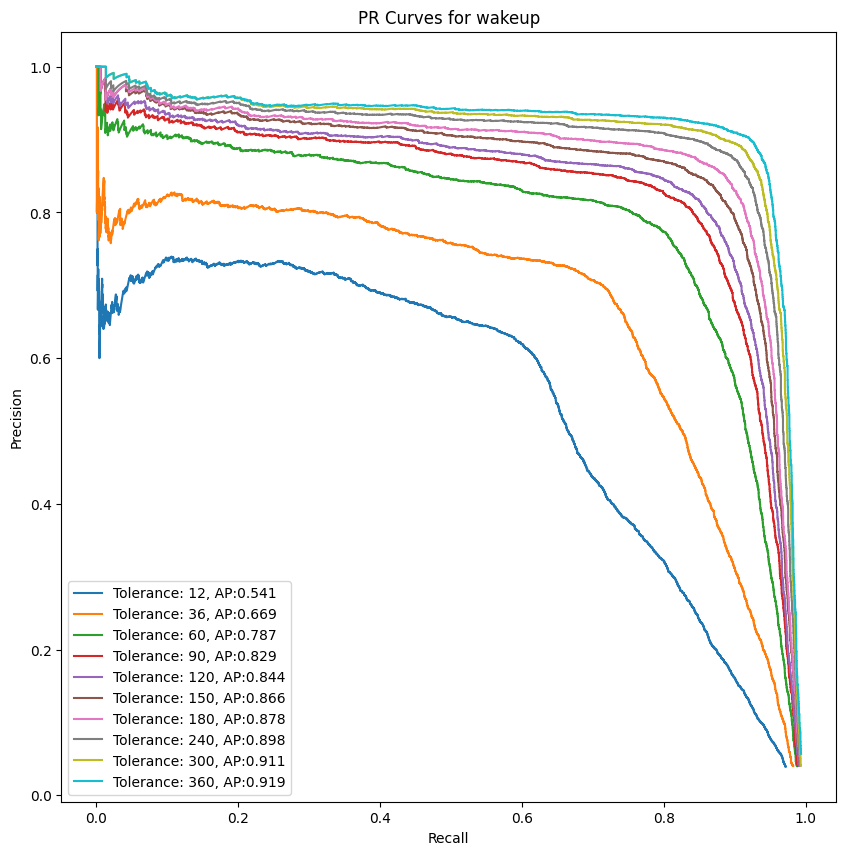

In [14]:
import matplotlib.pyplot as plt
for event in ["onset", "wakeup"]:
    plt.figure(figsize=(10, 10))
    for (event_key, tolerance), group in table[table.index.get_level_values("event") == event].iterrows():
        plt.plot(
            group["recall"][:-1], group["precision"][:-1], label=f'Tolerance: {tolerance}, AP:{group["ap"]:.3f}'
        )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curves for {event}")
    plt.legend()
    plt.show()